<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [17]:
#Start Here

from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

import spacy

import pandas as pd

In [18]:
pwd

'/Users/josephbell/Desktop/DS-Unit-4-Sprint-1-NLP/module4-topic-modeling'

In [19]:
df = pd.read_csv('../module1-text-data/data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19 2.csv')

In [20]:
df.shape

(28332, 24)

In [21]:
nlp = spacy.load("en_core_web_lg")

In [22]:
tokens = []

for doc in nlp.pipe(df['reviews.text'], batch_size=500):

    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.lemma_.lower())
            
    tokens.append(doc_tokens)

df['tokens'] = tokens

del tokens        

In [58]:
#create id2word
id2word = Dictionary(df['tokens'])
print(len(id2word))

8902


In [60]:
# word has to appear in 5 documents 
# no words in top 2% across all documents
id2word.filter_extremes(no_below=5, no_above=.5) 
print(len(id2word))

2957


In [25]:
#create corpus object
corpus = [id2word.doc2bow(d) for d in df['tokens']]

In [28]:
from gensim.models.coherencemodel import CoherenceModel
def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated
    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    for iter_ in range(passes):
        print(f"=== Pass {iter_ + 1} of {passes} ===")
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=12, passes=5)
            print(f"Model with {num_topics} topics completed.")
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })
        print('\n')
    return coherence_values

In [30]:
# Can take a long time to run.
coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus,
                                                        start=2, 
                                                        limit=40, 
                                                        step=2,
                                                        passes=1)

=== Pass 1 of 1 ===
Model with 2 topics completed.
Model with 4 topics completed.
Model with 6 topics completed.
Model with 8 topics completed.
Model with 10 topics completed.
Model with 12 topics completed.
Model with 14 topics completed.
Model with 16 topics completed.
Model with 18 topics completed.
Model with 20 topics completed.
Model with 22 topics completed.
Model with 24 topics completed.
Model with 26 topics completed.
Model with 28 topics completed.
Model with 30 topics completed.
Model with 32 topics completed.
Model with 34 topics completed.
Model with 36 topics completed.
Model with 38 topics completed.




In [31]:
topic_coherence = pd.DataFrame.from_records(coherence_values)

In [32]:
topic_coherence.head()

,pass,num_topics,coherence_score
0,0,2,-2.203674
1,0,4,-2.329291
2,0,6,-2.459155
3,0,8,-2.392581
4,0,10,-2.375270


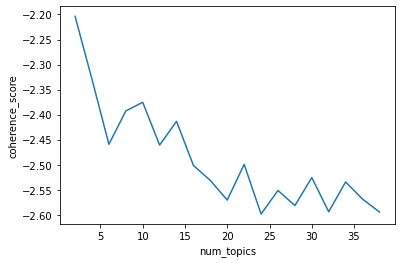

In [33]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

In [35]:
lda = LdaMulticore(corpus=corpus, num_topics=20, id2word=id2word, workers=12, passes=100)

In [37]:
import re
words = [re.findall(r'"([^"]*)"', t[1]) for t in lda.print_topics()]

In [39]:
topics = [' '.join(t[0:5]) for t in words]

In [40]:
topics

['battery long brand price work',
 'battery life good great pretty',
 'kid tablet child great recommend',
 'fire kindle love 8 hd',
 'screen like ad help issue',
 'nice size screen great tablet',
 'easy use tablet great love',
 'ipad tablet amazon $ want',
 'year old love game tablet',
 'charge device kindle turn hold',
 'work fine problem fit case',
 'battery use box remote buy',
 'buy good product item happy',
 'app tablet amazon google store',
 'like great alexa amazon sound',
 'time tablet 5 work star',
 'love buy gift christmas daughter',
 'read book kindle love reader',
 'great price good tablet product',
 'movie tablet watch game great']

In [41]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.157824 -0.167410       1        1  10.112391
0     -0.281354  0.021127       2        1   9.206280
8      0.211338 -0.009630       3        1   7.728288
18    -0.134444  0.275712       4        1   6.411333
17     0.133910 -0.059343       5        1   5.267188
16     0.208206 -0.043909       6        1   5.215348
3      0.132572 -0.092223       7        1   4.952890
2      0.110812  0.171287       8        1   4.861019
13     0.034062  0.059944       9        1   4.851699
9     -0.011521 -0.229290      10        1   4.751804
1     -0.259868  0.077526      11        1   4.362910
19     0.084327  0.130727      12        1   4.266130
12    -0.101643 -0.026595      13        1   4.212701
6      0.168598  0.132772      14        1   4.180493
7     -0.043505  0.027318      15        1   4.177600
14    -0.081417  0.039451      16        1   3.718488
5      0.034379  0.126589      17        1   3.520345
4     -0.014339 -0.183247      18        1   3.014145
10    -0.049006 -0.151009      19        1   2.741826
15     0.016718 -0.099798      20        1   2.447126, topic_info=         Term         Freq        Total Category  logprob  loglift
3     battery  9043.000000  9043.000000  Default  30.0000  30.0000
32       easy  3266.000000  3266.000000  Default  29.0000  29.0000
18      price  4724.000000  4724.000000  Default  28.0000  28.0000
86        use  4748.000000  4748.000000  Default  27.0000  27.0000
82       love  5830.000000  5830.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
199         4    63.709869   708.273804  Topic20  -4.8073   1.3018
38   purchase    68.171608  2531.610596  Topic20  -4.7397   0.0957
274      come    58.645332  1172.783691  Topic20  -4.8902   0.7146
96       need    56.329174  1817.802979  Topic20  -4.9305   0.2361
86        use    54.608337  4748.470215  Topic20  -4.9615  -0.7551

[1385 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2341     15  0.938904       $
2341     18  0.057957       $
374       1  0.283161       1
374       3  0.457103       1
374       6  0.020226       1
...     ...       ...     ...
1073      6  0.256403      yr
1011     13  0.885089     yup
2265     19  0.885833  zipper
1304      3  0.903684    zone
2881     14  0.936352       ©

[3294 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 1, 9, 19, 18, 17, 4, 3, 14, 10, 2, 20, 13, 7, 8, 15, 6, 5, 11, 16])

In [43]:
list(df)

['id',
 'dateAdded',
 'dateUpdated',
 'name',
 'asins',
 'brand',
 'categories',
 'primaryCategories',
 'imageURLs',
 'keys',
 'manufacturer',
 'manufacturerNumber',
 'reviews.date',
 'reviews.dateSeen',
 'reviews.didPurchase',
 'reviews.doRecommend',
 'reviews.id',
 'reviews.numHelpful',
 'reviews.rating',
 'reviews.sourceURLs',
 'reviews.text',
 'reviews.title',
 'reviews.username',
 'sourceURLs',
 'tokens']

In [42]:
df['primaryCategories'].value_counts()

Electronics                    13995
Health & Beauty                12071
Toys & Games,Electronics        1676
Office Supplies,Electronics      386
Electronics,Media                185
Office Supplies                    9
Animals & Pet Supplies             6
Home & Garden                      2
Electronics,Furniture              2
Name: primaryCategories, dtype: int64

In [ ]:
# what are the topics associated with Electronics?

In [ ]:
# how are topics correlated with rating?

In [45]:
# Are certain topics more helpful?

df['reviews.numHelpful'].value_counts()

0.0      14878
1.0        589
2.0        256
3.0         82
4.0         58
         ...  
47.0         1
621.0        1
55.0         1
45.0         1
220.0        1
Name: reviews.numHelpful, Length: 61, dtype: int64

In [47]:
# Continuous Variable
new_distro[0]

NameError: name 'new_distro' is not defined

In [ ]:
topics_df = pd.DataFrame

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling